<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# KNN Classification and Imputation: Cell Phone Churn Data

_Authors: Kiefer Katovich (SF)_

---

In this lab you will practice using KNN for classification (and a little bit for regression as well).

The dataset is one on "churn" in cell phone plans. It has information on the usage of the phones by different account holders and whether or not they churned or not.

Our goal is to predict whether a user will churn or not based on the other features.

We will also be using the KNN model to **impute** missing data. There are a couple of columns in the dataset with missing values, and we can build KNN models to predict what those missing values will most likely be. This is a more advanced imputation method than just filling in the mean or median.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.neighbors import KNeighborsClassifier

### 1. Load the cell phone "churn" data containing some missing values.

In [2]:
churn = pd.read_csv('/Users/Mahendra/desktop/GA/hw/6.3.2_classification-knn_imputation-lab/datasets/churn_missing.csv')
churn.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,KS,128,415,no,yes,25.0,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26.0,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0.0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0.0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0.0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### 2. Examine the data. What columns have missing values?

In [3]:
# A:
churn.isnull().sum()

state               0
account_length      0
area_code           0
intl_plan           0
vmail_plan        400
vmail_message     400
day_mins            0
day_calls           0
day_charge          0
eve_mins            0
eve_calls           0
eve_charge          0
night_mins          0
night_calls         0
night_charge        0
intl_mins           0
intl_calls          0
intl_charge         0
custserv_calls      0
churn               0
dtype: int64

In [4]:
churn.shape

(3333, 20)

In [5]:
print churn['vmail_plan'].nunique()

2


In [6]:
for item in churn:
    print item
    print churn[item].value_counts(dropna=False)

state
WV    106
MN     84
NY     83
AL     80
WI     78
OH     78
OR     78
WY     77
VA     77
CT     74
MI     73
ID     73
VT     73
TX     72
UT     72
IN     71
KS     70
MD     70
MT     68
NJ     68
NC     68
NV     66
WA     66
CO     66
MS     65
RI     65
MA     65
AZ     64
MO     63
FL     63
NM     62
ME     62
ND     62
DE     61
OK     61
NE     61
SC     60
SD     60
KY     59
IL     58
NH     56
AR     55
DC     54
GA     54
TN     53
HI     53
AK     52
LA     51
PA     45
IA     44
CA     34
Name: state, dtype: int64
account_length
105    43
87     42
93     40
101    40
90     39
86     38
95     38
116    37
100    37
112    36
107    36
99     36
120    35
127    35
123    35
106    34
122    34
88     34
103    33
80     33
92     33
94     33
98     32
74     32
119    32
117    32
73     32
75     32
64     32
113    32
       ..
9       3
7       2
204     2
186     2
210     2
212     2
195     2
224     2
196     2
18      2
205     2
225     2
6       2
217

### 3. Convert the `vmail_plan` and `intl_plan` colums to binary integer columns.

Make sure that if a value is missing that you don't fill it in with a new value! Preserve the missing values.

In [7]:
# A:
churn.loc[:,'vmail_plan'] = churn.vmail_plan.map(lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
churn.loc[:,'intl_plan'] = churn.intl_plan.map(lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)

### 4. Create dummy coded columns for state and concatenate it to the churn dataset.

> **Remember:** You will need to leave out one of the state dummy coded columns to serve as the "reference" column since we will be using these for modeling.

In [8]:
states = pd.get_dummies(churn.state, drop_first=True)
states.head(3)

,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
churn = pd.concat([churn, states], axis=1)

### 5. Create a version of the churn data that has no missing values.

Calculate the shape

In [10]:
# A:
churn.shape

(3333, 70)

In [11]:
churn_nonv=churn.dropna()
churn_nonv.shape

(2933, 70)

### 6. Create a target vector and predictor matrix.

- Target should be the `churn` column.
- Predictor matrix should be all columns except `area_code`, `state`, and `churn`.

In [12]:
# A:
churn_nonv.columns

Index([u'state', u'account_length', u'area_code', u'intl_plan', u'vmail_plan',
       u'vmail_message', u'day_mins', u'day_calls', u'day_charge', u'eve_mins',
       u'eve_calls', u'eve_charge', u'night_mins', u'night_calls',
       u'night_charge', u'intl_mins', u'intl_calls', u'intl_charge',
       u'custserv_calls', u'churn', u'AL', u'AR', u'AZ', u'CA', u'CO', u'CT',
       u'DC', u'DE', u'FL', u'GA', u'HI', u'IA', u'ID', u'IL', u'IN', u'KS',
       u'KY', u'LA', u'MA', u'MD', u'ME', u'MI', u'MN', u'MO', u'MS', u'MT',
       u'NC', u'ND', u'NE', u'NH', u'NJ', u'NM', u'NV', u'NY', u'OH', u'OK',
       u'OR', u'PA', u'RI', u'SC', u'SD', u'TN', u'TX', u'UT', u'VA', u'VT',
       u'WA', u'WI', u'WV', u'WY'],
      dtype='object')

In [13]:
y= churn_nonv.churn.values
x=churn_nonv[[c for c in churn_nonv.columns if not c in ['area_code','state','churn']]]

### 7. Calculate the baseline accuracy for `churn`.

In [14]:
# A:
baseline=1-np.mean(y)
baseline

0.85646096147289463

### 8. Cross-validate a KNN model predicting `churn`. 

- Number of neighbors should be 5.
- Make sure to standardize the predictor matrix.
- Set cross-validation folds to 10.

Report the mean cross-validated accuracy.

In [15]:
# A:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
knn=KNeighborsClassifier(n_neighbors=5)
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [16]:
ss = StandardScaler()
xs = ss.fit_transform(x)

### 9. Iterate from k=1 to k=49 (only odd k) and cross-validate the accuracy of the model for each.

Plot the cross-validated mean accuracy for each score. What is the best accuracy?

In [17]:
# A:
scores = cross_val_score(knn, xs, y, cv=10)
print scores
print np.mean(scores)

[ 0.84745763  0.86054422  0.86006826  0.85665529  0.87030717  0.85665529
  0.85665529  0.85324232  0.85665529  0.85665529]
0.857489604276


In [18]:
# A:
k_values= range(1,50,2)
arr=[]
for k in k_values:
    knn=KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, xs, y, cv=10)
    arr.append(np.mean(scores))


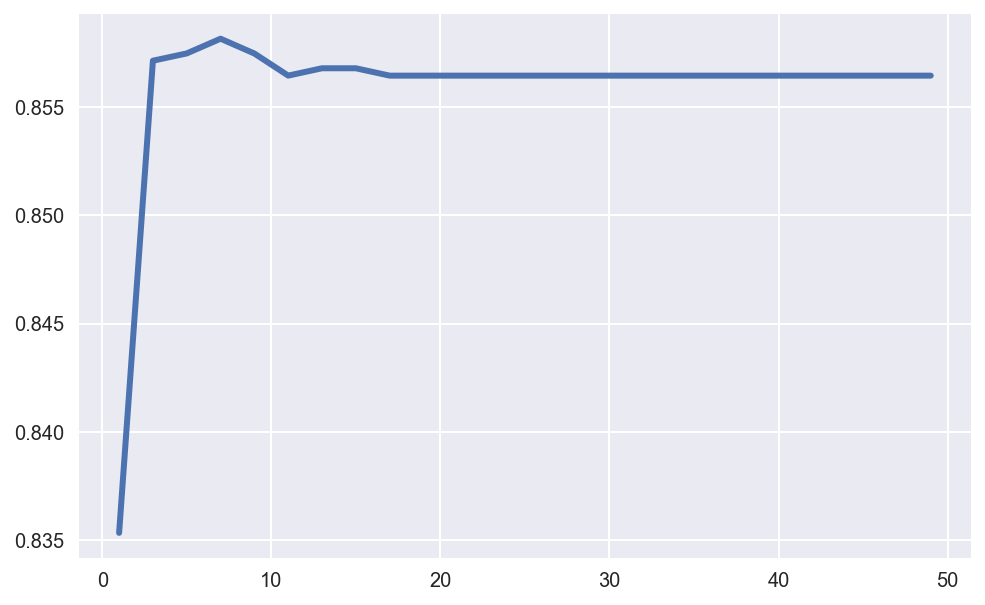

0.858169892125


In [19]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(k_values, arr, lw=3)
plt.show()

print np.max(arr)

### 10. Imputing with KNN

K-Nearest Neighbors can be used to impute missing values in datasets. What we will do is estimate the most likely value for the missing data based on a KNN model.

We have two columns with missing data:
- `vmail_plan`
- `vmail_message`

**10.A Create two subsets of the churn dataset: one without missing values for `vmail_plan` and `vmail_message`, and one with the missing values.**

In [20]:
from sklearn.neighbors import KNeighborsRegressor
missing_cols = ['vmail_plan','vmail_message']

In [21]:
impute_missing = churn.loc[churn.vmail_plan.isnull(), :]
impute_valid = churn.loc[~churn.vmail_plan.isnull(), :]
print impute_valid.columns
print impute_missing.columns

Index([u'state', u'account_length', u'area_code', u'intl_plan', u'vmail_plan',
       u'vmail_message', u'day_mins', u'day_calls', u'day_charge', u'eve_mins',
       u'eve_calls', u'eve_charge', u'night_mins', u'night_calls',
       u'night_charge', u'intl_mins', u'intl_calls', u'intl_charge',
       u'custserv_calls', u'churn', u'AL', u'AR', u'AZ', u'CA', u'CO', u'CT',
       u'DC', u'DE', u'FL', u'GA', u'HI', u'IA', u'ID', u'IL', u'IN', u'KS',
       u'KY', u'LA', u'MA', u'MD', u'ME', u'MI', u'MN', u'MO', u'MS', u'MT',
       u'NC', u'ND', u'NE', u'NH', u'NJ', u'NM', u'NV', u'NY', u'OH', u'OK',
       u'OR', u'PA', u'RI', u'SC', u'SD', u'TN', u'TX', u'UT', u'VA', u'VT',
       u'WA', u'WI', u'WV', u'WY'],
      dtype='object')
Index([u'state', u'account_length', u'area_code', u'intl_plan', u'vmail_plan',
       u'vmail_message', u'day_mins', u'day_calls', u'day_charge', u'eve_mins',
       u'eve_calls', u'eve_charge', u'night_mins', u'night_calls',
       u'night_charge', u'intl_mins

First we will impute values for `vmail_plan`. This is a categorical column and so we will impute using classification (predicting whether the plan is yes or no, 1 vs. 0).

**10.B Create a target that is `vmail_plan` and predictor matrix that is all columns except `state`, `area_code`, `churn`, `vmail_plan`, and `vmail_message`.**

> **Note:** We don't include the `churn` variable in the model to impute. Why? We are imputing these missing values so that we can use the rows to predict churn with more data afterwards. If we imputed with churn as a predictor then we would be cheating.

In [22]:
# A:
impute_cols = [c for c in impute_valid.columns if not c in ['state','area_code','churn']+missing_cols]

y = impute_valid.vmail_plan.values
X = impute_valid[impute_cols]

**10.C Standardize the predictor matrix.**

In [23]:
# A:
ss = StandardScaler()
Xs = ss.fit_transform(X)

**10.D Find the best K for predicting `vmail_plan`.**

You may want to write a function for this. What is the accuracy for predicting `vmail_plan` at the best K? What is the baseline accuracy for `vmail_plan`?

In [24]:
# A:
def find_best_k_cls(X, y, k_min=1, k_max=51, step=2, cv=5):
    k_range = range(k_min, k_max+1, step)
    accs = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv)
        accs.append(np.mean(scores))
    print np.max(accs), np.argmax(k_range)
    return np.argmax(k_range)

**10.E Fit a `KNeighborsClassifier` with the best number of neighbors.**

In [25]:
# A:
find_best_k_cls(xs,y)

0.958740282922 25


25

In [30]:
vmail_plan_baseline = 1. - impute_valid.vmail_plan.mean()
print vmail_plan_baseline

0.72621888851


**10.F Predict the missing `vmail_plan` values using the subset of the data where it is misssing.**

You will need to:
1. Create a new predictor matrix using the same predictors but from the missing subset of data.
- Standardize this predictor matrix *using the StandardScaler object fit on the non-missing data*. This means you will just use the `.transform()` function. It is important to standardize the new predictors the same way we standardized the original predictors if we want the predictions to make sense.
- Predict what the missing vmail plan values should be.
- Replace the missing values in the original with the predicted values.

> **Note:** It may predict all 0's. This is OK. If you want to see the predicted probabilities of `vmail_plan` for each row you can use the `.predict_proba()` function instead of `.predict()`

In [26]:
# A:

### 11. Impute the missing values for `vmail_message` using the same process.

Since `vmail_message` is essentially a continuous measure, you need to use `KNeighborsRegressor` instead of the `KNeighborsClassifier`.

KNN can do both regression and classification! Instead of "voting" on the class like in classification, the neighbors will average their value for the target in regression.

In [27]:
# A:

### 12. Given the accuracy (and $R^2$) of your best imputation models when finding the best K neighbors, do you think imputing is a good idea?

In [28]:
# A:

### 13. With the imputed dataset, cross-validate the accuracy predicting churn. Is it better? Worse? The same?

In [29]:
# A: